In [1]:
import h5py
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import glob
from biosppy.signals import tools as st
from scipy import stats

In [2]:
SCALER = 'fir'
DATAPATH = '../../data/ecg/raw/2019-11-19'
ecg_key_string_list = [
    "strip_I",
    "strip_II",
    "strip_III"
]

In [3]:
hdf5_files = []
count = 0
for f in glob.glob("{}/*.hd5".format(DATAPATH)):
    count += 1
    if count > 7000:
        break
    hdf5_files.append(f)

print('Data Loading finished (row:{})'.format(len(hdf5_files)))

Data Loading finished (row:7000)


In [35]:
def scale_maxabs(arr, maxabs, thres):
    arr = (arr / maxabs) * thres
    return arr

In [31]:
def apply_threshold(arr, thres):
    arr[arr > thres] = thres
    arr[arr < -thres] = thres
    return arr

In [23]:
# Load data 
x_all = []
y_all = []
for hdf_file in hdf5_files:
    f = h5py.File(hdf_file, 'r')
    y_all.append(f['continuous']['VentricularRate'][0])
    x_list = list()
    for (i, key) in enumerate(ecg_key_string_list):
        x = f['ecg_rest'][key][:]
        x_list.append(x)
    x_list = np.stack(x_list)
    x_list = x_list.reshape([3, 12 // 12, 500, 5000 // 500]).mean(3).mean(1)
    
    # filter garbage data     
    if np.max(np.abs(x_list)) > 1000:
        continue
        
    if f['continuous']['VentricularRate'][0] > 150 or f['continuous']['VentricularRate'][0] < 20:
        continue
    
    x_all.append(x_list)

x = np.asarray(x_all)
y = np.asarray(y_all)

# add filter
for i in range(x.shape[1]):
    part_x = x[:, i, :]
    print('train_x m, s: ', part_x.mean(), part_x.std())
    print('train_x min, max: ', part_x.min(), part_x.max())

    if SCALER == 'minmax':
        part_x = scale_minmax(part_x, part_x.min(), part_x.max())
    elif SCALER == 'maxabs':
        part_x = scale_maxabs(part_x, np.max(np.abs(part_x)), 100)
    elif SCALER == 'fir':
        order = int(0.3 * 100)
        filtered, _, _ = st.filter_signal(signal=part_x,
                                          ftype='FIR',
                                          band='bandpass',
                                          order=order,
                                          frequency=[3, 45],
                                          sampling_rate=100)
        part_x = filtered

    x[:, i, :] = part_x

x = x.reshape(x.shape[0], -1)

train_x m, s:  10.908997695520675 132.04637588542246
train_x min, max:  -969.8 984.3
train_x m, s:  1.7234278841999129 153.00526061775855
train_x min, max:  -991.1 990.5
train_x m, s:  -9.194922713524418 155.00859852980196
train_x min, max:  -1000.0 972.9


In [24]:
x.shape

(6943, 1500)

In [32]:
rand = np.random.RandomState(42)
random_index = rand.randint(6943, size=1000)
x_random = x[random_index, :]
x_random.shape

(1000, 1500)

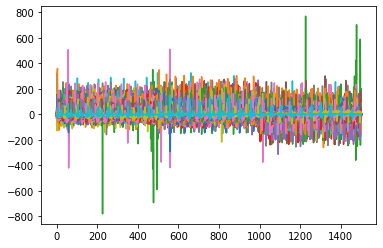

In [26]:
# plot random X
for i in range(x_random.shape[0]):
    plt.plot(x_random[i, :])

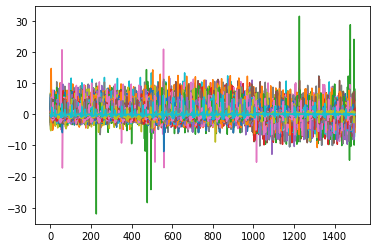

In [27]:
# previous data preprocessing
previous_x = scale_maxabs(x_random, np.max(np.abs(x_random)), 32)
for i in range(previous_x.shape[0]):
    plt.plot(previous_x[i, :])

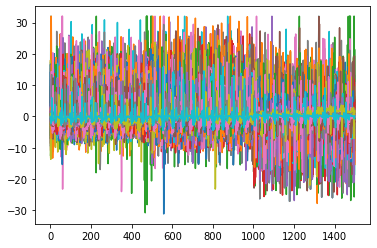

In [36]:
# current data preprocessing

# 1. cut out if abs(x) is above 500. 
x_random_cut = apply_threshold(x_random, 300)
            
# 2. normalize to -32 ~ 32
current_x = scale_maxabs(x_random_cut, np.max(np.abs(x_random_cut)), 32)

# Plot
for i in range(current_x.shape[0]):
    plt.plot(current_x[i, :])